### Import Libraries

In [1]:
"If it does not work use code below while running this notebook in this dir."
# import sys
# import os
# sys.path.append(os.path.abspath(os.getcwd()))

from mytorch import Tensor, Model
from mytorch import activation as active_func
from mytorch import loss as loss_func
from mytorch import optimizer as optim 
from mytorch import layer as nn
from mytorch.util import DataLoader
import matplotlib.pyplot as plt
import numpy as np

### Load MNIST

In [2]:
data_loader = DataLoader(train_addr='MNIST/train', test_addr='MNIST/test')
data_loader.load()

trainloader = data_loader.getTrain()
testloader = data_loader.getTest()

"you can see how data is loaded"
# print(data_loader.getTrain()[0][0].shape)
# print(data_loader.getTrain()[0][1].shape)

loading train...
loading test...
processing...


'you can see how data is loaded'

### Define and Create your Model

In [3]:
# Define and Create your Model
class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.conv2 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        self.pool = nn.MaxPool2d(1,2,kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
        self.fc1 = nn.Linear(64 * 7 * 7, 128, need_bias=True)
        self.fc2 = nn.Linear(128, 10, need_bias=True)
        self.relu = active_func.relu
        self.layers = [
            self.conv1,
            self.conv2,
            self.fc1,
            self.fc2,
        ]


    def forward(self, x: Tensor) -> Tensor:
        if len(x.shape) == 3:  # Add channel dimension if missing
            x.data = np.expand_dims(x.data, axis=1)
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.reshape((-1, 64 * 7 * 7))
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = MyModel()
print(model.summary())

### Choose a Loss Function

In [4]:
"TODO: choose a proper loss function"
criterion = loss_func.CategoricalCrossEntropy

### Choose an Optimizer

In [10]:
"TODO: choose a proper optimizer"
optimizer = optim.SGD(model.layers, learning_rate=0.01)

### Training Model

In [11]:
training_data_images = []
training_data_labels = []

for image_batch, label_batch in trainloader:
    for idx in range(500):
        normalized_image = image_batch.data[idx] / 255.0
        training_data_images.append(normalized_image) 
    training_data_labels.extend(label_batch)

training_data_images = Tensor(np.array(training_data_images), requires_grad=True)
training_data_labels = Tensor(np.array(training_data_labels), requires_grad=True)


testing_data_images = []
testing_data_labels = []
for image_batch, label_batch in testloader:
    for idx in range(100):
        normalized_image = image_batch.data[idx] / 255.0
        testing_data_images.append(normalized_image)
    testing_data_labels.extend(label_batch)

testing_data_images = Tensor(np.array(testing_data_images), requires_grad=True)
testing_data_labels = Tensor(np.array(testing_data_labels), requires_grad=True)

# Set training parameters
TOTAL_EPOCHS = 30
SAMPLE_BATCH_SIZE = 50
train_acc = []
test_acc = []
best_train_acc = 0.0
best_test_acc = 0.0

# Training and evaluation loop
for epoch in range(TOTAL_EPOCHS):
    model.train()
    train_correct = 0
    train_total = 0
    for batch_start in range(0, training_data_images.shape[0], SAMPLE_BATCH_SIZE):
        batch_inputs = training_data_images[batch_start:batch_start + SAMPLE_BATCH_SIZE]
        batch_labels = training_data_labels[batch_start:batch_start + SAMPLE_BATCH_SIZE]
        optimizer.zero_grad()
        batch_outputs = model(batch_inputs)
        loss_value = criterion(batch_outputs, batch_labels)
        grad_tensor = Tensor(np.ones(loss_value.data.shape))
        loss_value.backward(grad_tensor)
        optimizer.step()

        batch_predictions = np.argmax(batch_outputs.data, axis=1)
        train_total += batch_labels.shape[0]
        for idx in range(SAMPLE_BATCH_SIZE):
            if batch_predictions[idx] == int(batch_labels.data[idx].data.item()):
                train_correct += 1

    epoch_train_accuracy = 100 * train_correct / train_total
    train_acc.append(epoch_train_accuracy)
    if epoch_train_accuracy > best_train_acc:
        max_train_accuracy = epoch_train_accuracy

    print("finished train")
    model.eval()
    test_correct = 0
    test_total = 0
    for batch_start in range(0, testing_data_images.shape[0], SAMPLE_BATCH_SIZE):
        batch_inputs = testing_data_images[batch_start:batch_start + SAMPLE_BATCH_SIZE]
        batch_labels = testing_data_labels[batch_start:batch_start + SAMPLE_BATCH_SIZE]
        batch_outputs = model(batch_inputs)
        batch_predictions = np.argmax(batch_outputs.data, axis=1)
        test_total += batch_labels.shape[0]
        for idx in range(SAMPLE_BATCH_SIZE):
            if batch_predictions[idx] == int(batch_labels.data[idx].data.item()):
                test_correct += 1

    epoch_test_accuracy = 100 * test_correct / test_total
    test_acc.append(epoch_test_accuracy)
    if epoch_test_accuracy > best_test_acc:
        max_test_accuracy = epoch_test_accuracy

    print(f'Epoch {epoch + 1}/{TOTAL_EPOCHS}, Train Accuracy: {epoch_train_accuracy:.2f}%, Test Accuracy: {epoch_test_accuracy:.2f}%')


finished train
Epoch 1/30, Train Accuracy: 66.22%, Test Accuracy: 80.70%
finished train
Epoch 2/30, Train Accuracy: 85.57%, Test Accuracy: 84.90%
finished train
Epoch 3/30, Train Accuracy: 88.63%, Test Accuracy: 87.30%
finished train
Epoch 4/30, Train Accuracy: 89.95%, Test Accuracy: 88.10%
finished train
Epoch 5/30, Train Accuracy: 90.77%, Test Accuracy: 89.00%
finished train
Epoch 6/30, Train Accuracy: 91.48%, Test Accuracy: 89.50%
finished train
Epoch 7/30, Train Accuracy: 92.02%, Test Accuracy: 90.30%


KeyboardInterrupt: 

### Evaluate Model Performance

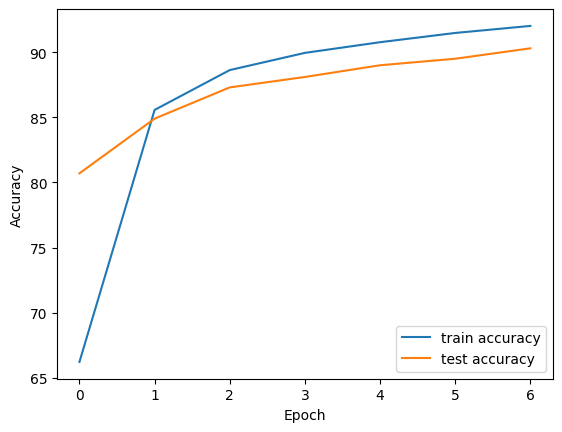


On train - best accuracy: 0.00, final accuracy: 92.02
On test - best accuracy: 0.00, final accuracy: 90.30


In [12]:
plt.plot(train_acc, label='train accuracy')
plt.plot(test_acc, label='test accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

print("\nOn train - best accuracy: {:.2f}, final accuracy: {:.2f}".format(best_train_acc, train_acc[-1]))
print("On test - best accuracy: {:.2f}, final accuracy: {:.2f}".format(best_test_acc, test_acc[-1]))